In [173]:
# -*- coding: utf-8 -*-
"""Use to generate summary statistics in simulated and real time series.

Attributes
----------
SUMMARY : dict
    Dictionary containing the distance aliases, mapping to the functions.

"""
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sys
import os
import matplotlib. pyplot as plt
# sys.path.append(os.path.abspath(os.path.dirname(__file__)))


class Error(Exception):
    """Base class for exceptions in this module."""

    pass


class ZeroArrayError(Error):
    """Exception raised for errors in the zero array."""

    pass

def zero_array(array, zero_flag):
    """Zero an array of data with its initial values.

    Parameters
    ----------
    array : list
        List of data
    zero_flags : bool
        Boolean indicating if data needs zeroing
    Returns
    -------
    zerod : list
        Zero'd list

    """
    if zero_flag:
        init = float(array[0])
        zerod = [x - init for x in array]
    else:
        zerod = array
    return zerod

class SummaryStats:
    """
    Generate summary statistics from time series data.

    This class will find a range of summary statistics for time series data.

    Parameters
    ----------
    actual_data : dict
        Dictionary of data, as generated by
        :meth:`bayescmd.abc.data_import.import_actual_data` or
        :meth:`bayescmd.bcmdModel.ModelBCMD.output_parse`.

    targets : list of :obj:`str`
        List of model targets, which should all be strings.

    zero_flag : dict
        Dictionary of form target(:obj:`str`): bool, where bool indicates
        whether to zero that target.

        Note: zero_flag keys should match targets list.

    Returns
    -------
    distances : dict
        Dictionary of form:
            {'TOTAL': summed distance of all signals,
            'target1: distance of 1st target',
            ...
            'targetN': distance of Nth target
            }
    """


    def __init__(self, data, targets, zero_flag, observed_data=None):


        self.d0 = {k : zero_array(data[k], zero_flag[k]) for k in targets}
        self.summary_stats = {k: {} for k in self.d0.keys()}
        self.autocorrelation = {k: {} for k in self.d0.keys()}
        if observed_data is not None:
            self.residuals = {k: self.d0[k] - observed_data[k] for k in self.d0.keys()}
            self.residual_autocorrelation = {k: {} for k in self.d0.keys()}
        else:
            self.residuals=None
        
    def get_mean(self):
        for k, data in self.d0.items():
            self.summary_stats[k]['mean'] = np.mean(data)

    def get_variance(self):
        for k, data in self.d0.items():
            self.summary_stats[k]['variance'] = np.var(data)
            self.summary_stats[k]['std'] = np.std(data)
        
    def get_autocorr(self):

        def autocorr(y):
            yunbiased = y-np.mean(y)
            ynorm = np.sum(yunbiased**2)
            acor = np.correlate(yunbiased, yunbiased, "same")/ynorm
            # use only second half
            acor = acor[len(acor)//2:]
            return acor
        
        for k, data in self.d0.items():
            self.autocorrelation[k] = autocorr(data)
            
            if self.residuals:
                self.residual_autocorrelation[k] = autocorr(self.residuals[k])
        
        
    def get_stats(self):
        self.get_mean()
        self.get_variance()
        self.get_autocorr()

        

## Generate some data to test this with ##

In [178]:
def summary_test(n=25):
    results = {}
    observed_data = np.random.randn(3, 100)
    observed_data = np.vstack([observed_data, np.sin(np.linspace(0,360,100) * np.pi / 180. )+np.random.randn(1, 100)])
    observed_data[1,:] = observed_data[1,:]-observed_data[1,0]
    observed_data[3,:] = observed_data[3,:]-observed_data[3,0]
    targets = ['a', 'b', 'c', 'd']
    trueData = {k: observed_data[i] for i, k in enumerate(targets) }
    for i in range(n):
        results[i] = {}
        random_data = np.random.randn(3, 100)
        random_data = np.vstack([random_data, np.sin(np.linspace(0,360,100) * np.pi / 180. )])
        zero_flag = {k: flag for k,flag in zip(targets, flags)}
        tsData = {k: random_data[i] for i, k in enumerate(targets) }
        summary_creator = SummaryStats(tsData, targets, zero_flag, observed_data=trueData)
        summary_creator.get_stats()
        results[i]['data'] = summary_creator.d0
        results[i]['stats'] = summary_creator.summary_stats
        results[i]['autocorr'] = summary_creator.autocorrelation
        results[i]['res_autocorr'] = summary_creator.residual_autocorrelation
        
    return results

In [179]:
test_stats = summary_test()


/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  

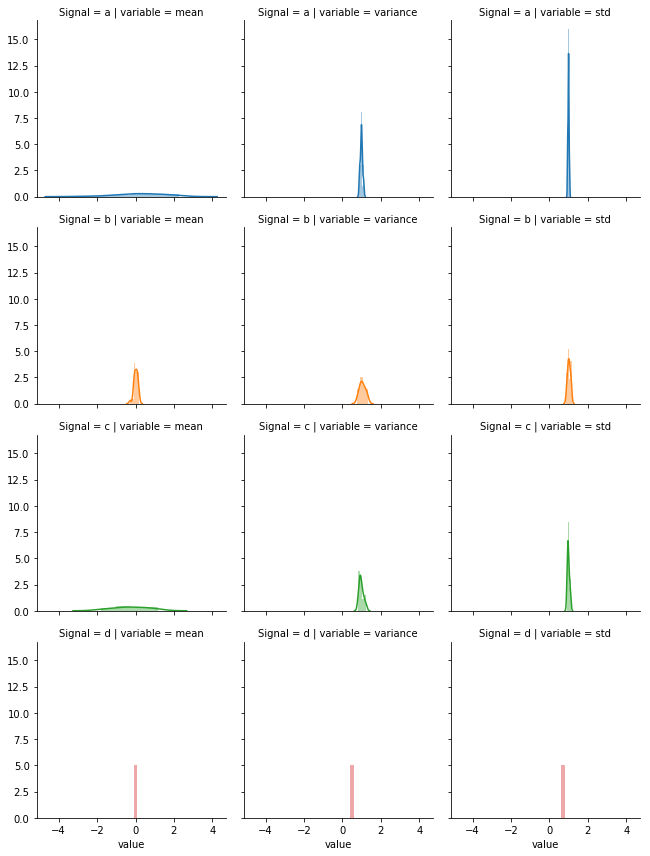

In [180]:
df = pd.DataFrame.from_dict({(i,j): test_stats[i]['stats'][j] 
                           for i in test_stats.keys() 
                           for j in test_stats[i]['stats'].keys()},
                       orient='index')
df.index.names = ['Batch', 'Signal']
df


melt_df = df.reset_index().melt(id_vars=['Signal'], value_vars=['mean', 'variance', 'std'])
g = sns.FacetGrid(melt_df, col="variable",  row="Signal", hue="Signal")
g = g.map(sns.distplot, 'value')

In [181]:
autocorr_formatted = [{'Batch' : i, 'Signal': j, 'autocorr' : v, 'lag': idx} for i in test_stats.keys() for j in test_stats[i]['autocorr'].keys() for idx, v in enumerate(test_stats[i]['autocorr'][j])]
df_ac = pd.DataFrame(autocorr_formatted) 

res_autocorr_formatted = [{'Batch' : i, 'Signal': j, 'res_autocorr' : v, 'lag': idx} for i in test_stats.keys() for j in test_stats[i]['res_autocorr'].keys() for idx, v in enumerate(test_stats[i]['res_autocorr'][j])]
df_res_ac = pd.DataFrame(res_autocorr_formatted) 

/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


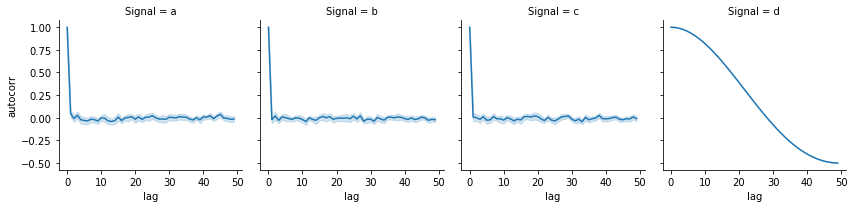

In [149]:
g = sns.FacetGrid(data=df_ac, col='Signal')
g.map(sns.lineplot, 'lag', 'autocorr')


/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


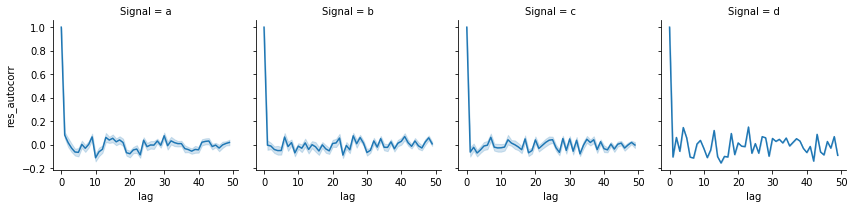

In [182]:
g = sns.FacetGrid(data=df_res_ac, col='Signal')
g.map(sns.lineplot, 'lag', 'res_autocorr')